In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

In [2]:
epochs = 10
image_size = (32, 32) # h x w
batch_size = 32

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train_splitted, x_val, y_train_splitted, y_val =\
    train_test_split(x_train, y_train, test_size=0.1, random_state=42)

x_train_splitted = (x_train_splitted - 127.5) / 127.5 #Normalizing
x_val = (x_val - 127.5) / 127.5 #Normalizing
x_test = (x_test - 127.5) / 127.5 #Normalizing

dataset_train = tf.data.Dataset.from_tensor_slices(
    (x_train_splitted, tf.reshape(tf.one_hot(y_train_splitted, 10), (-1, 10)))
).batch(batch_size, drop_remainder=True)

dataset_validation = tf.data.Dataset.from_tensor_slices(
    (x_val, tf.reshape(tf.one_hot(y_val, 10), (-1, 10)))
).batch(batch_size, drop_remainder=True)

dataset_test = tf.data.Dataset.from_tensor_slices(
    (x_test, tf.reshape(tf.one_hot(y_test, 10), (-1, 10)))
).batch(batch_size, drop_remainder=True)

170508288/170498071 [==============================] - 12s 0us/step


2022-05-01 14:57:40.976526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 14:57:41.075125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 14:57:41.076365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 14:57:41.079877: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
def scale_input_images(image_batch):
    result = []
    result.append(image_batch)
    result.append(tf.image.resize(image_batch, [16, 16]))
    result.append(tf.image.resize(image_batch, [8, 8]))
    result.append(tf.image.resize(image_batch, [4, 4]))
    
    return result

In [4]:
discriminator = keras.models.load_model('../input/msgdiscriminatorcifar10/msgDiscriminatorCifar10.h5')

In [5]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 128)  6272        input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 16, 16, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 16, 16, 128)  512         conv2d_4[0][0]                   
____________________________________________________________________________________________

In [6]:
cutted_discriminator = keras.Model(inputs=discriminator.input, outputs=discriminator.layers[-2].output)

In [7]:
cutted_discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 128)  6272        input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 16, 16, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 16, 16, 128)  512         conv2d_4[0][0]                   
______________________________________________________________________________________________

In [8]:
cutted_discriminator.trainable = False

In [9]:
# Az összerakott modell
inputs = keras.Input(shape=(32, 32, 3))
scaled_images = scale_input_images(inputs)
x = cutted_discriminator(scaled_images, training=False)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(10)(x)
outputs = keras.layers.Activation("softmax")(x)
model = keras.Model(inputs, outputs)

In [10]:
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [11]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
tf.image.resize (TFOpLambda)    (None, 16, 16, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.image.resize_1 (TFOpLambda)  (None, 8, 8, 3)      0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.image.resize_2 (TFOpLambda)  (None, 4, 4, 3)      0           input_1[0][0]                    
____________________________________________________________________________________________

In [12]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(dataset_validation)


2022-05-01 14:57:48.267469: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-01 14:57:49.027839: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


156/156 [==============================] - 7s 8ms/step - loss: 8.3617 - accuracy: 0.1220


In [13]:
print("initial loss: {:.4f}".format(loss0))
print("initial accuracy: {:.4f}".format(accuracy0))

initial loss: 8.3617
initial accuracy: 0.1220


In [14]:
history = model.fit(dataset_train,
                    epochs=initial_epochs,
                    validation_data=dataset_validation)

2022-05-01 14:57:58.615813: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1105920000 exceeds 10% of free system memory.
2022-05-01 14:57:59.354177: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1105920000 exceeds 10% of free system memory.


Epoch 1/10
1406/1406 [==============================] - 13s 9ms/step - loss: 6.3527 - accuracy: 0.1506 - val_loss: 4.3180 - val_accuracy: 0.2244


2022-05-01 14:58:13.534643: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1105920000 exceeds 10% of free system memory.


Epoch 2/10
1406/1406 [==============================] - 12s 9ms/step - loss: 4.2721 - accuracy: 0.2323 - val_loss: 3.1561 - val_accuracy: 0.3137
Epoch 3/10
1406/1406 [==============================] - 13s 9ms/step - loss: 3.2678 - accuracy: 0.2979 - val_loss: 2.5317 - val_accuracy: 0.3664
Epoch 4/10
1406/1406 [==============================] - 12s 9ms/step - loss: 2.6617 - accuracy: 0.3414 - val_loss: 2.1631 - val_accuracy: 0.4050
Epoch 5/10
1406/1406 [==============================] - 12s 9ms/step - loss: 2.2943 - accuracy: 0.3753 - val_loss: 1.9257 - val_accuracy: 0.4279
Epoch 6/10
1406/1406 [==============================] - 12s 9ms/step - loss: 2.0406 - accuracy: 0.3963 - val_loss: 1.7756 - val_accuracy: 0.4493
Epoch 7/10
1406/1406 [==============================] - 13s 9ms/step - loss: 1.8961 - accuracy: 0.4148 - val_loss: 1.6705 - val_accuracy: 0.4671
Epoch 8/10
1406/1406 [==============================] - 12s 9ms/step - loss: 1.7897 - accuracy: 0.4281 - val_loss: 1.5979 - val_ac

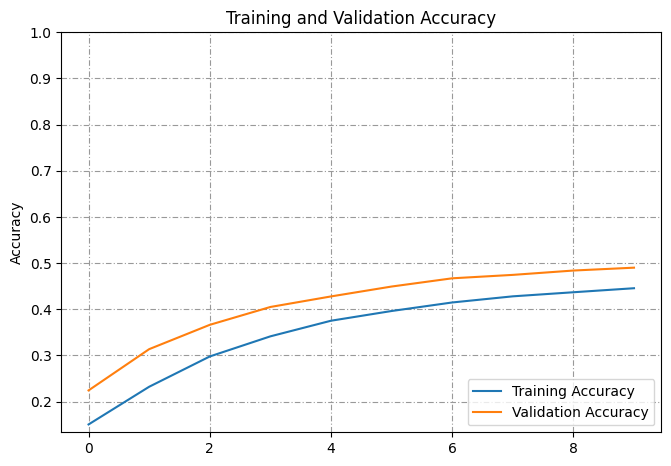

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig_1 = plt.figure(figsize=(6, 4), dpi=100)
ax = fig_1.add_axes([0, 0, 1, 1])
ax.grid(True, color='0.6', dashes=(5, 2, 1, 2))

ax.plot(acc, label='Training Accuracy')
ax.plot(val_acc, label='Validation Accuracy')
ax.legend(loc='lower right')
ax.set_ylabel('Accuracy')
ax.set_ylim([min(plt.ylim()),1])
ax.set_title('Training and Validation Accuracy')
plt.show()

In [16]:
loss, accuracy = model.evaluate(dataset_test)
print('Test accuracy :', accuracy)


312/312 [==============================] - 3s 8ms/step - loss: 1.5340 - accuracy: 0.4770
Test accuracy : 0.4769631326198578


In [17]:
model.save("cifar10Classifier.h5")

In [20]:
predictions = model.predict(x_test)
confusion_matrix = tf.math.confusion_matrix(y_test, predictions.argmax(axis=1))

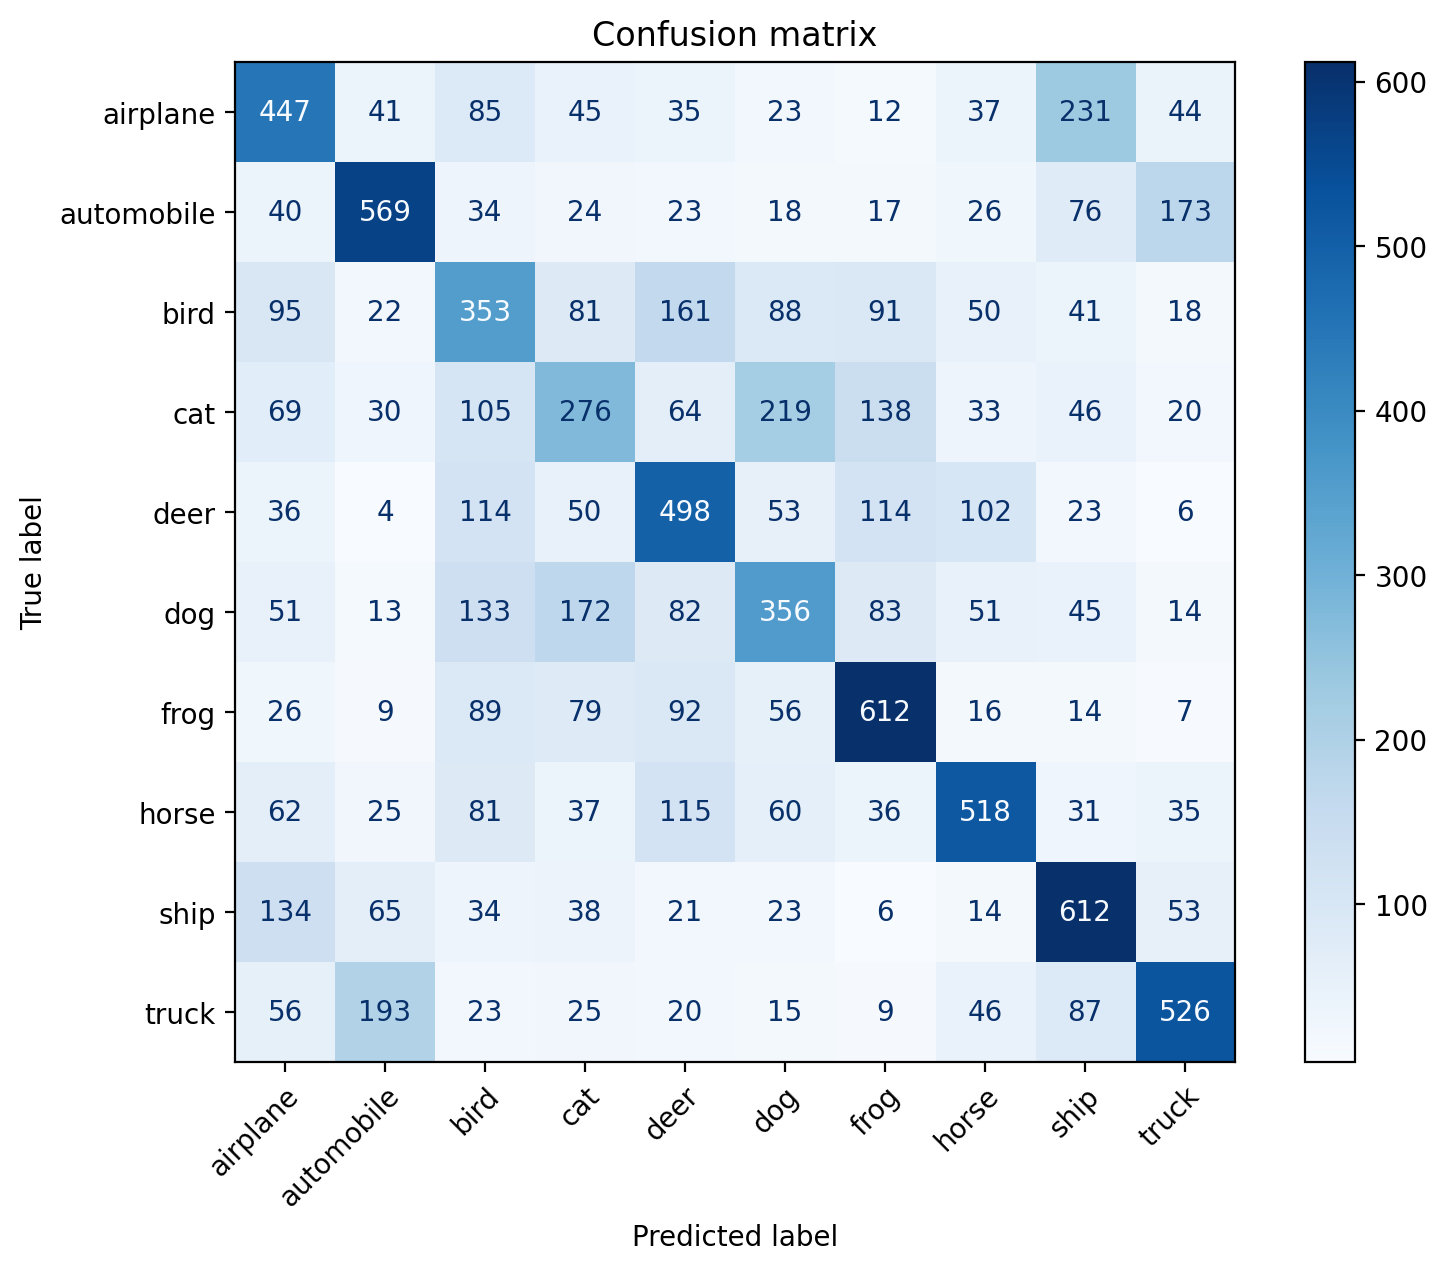

In [21]:
fig_1 = plt.figure(figsize=(7, 5), dpi=200)
ax = fig_1.add_axes([0, 0, 1, 1])
ax.set_title("Confusion matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix.numpy(),
                              display_labels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
plt.show()

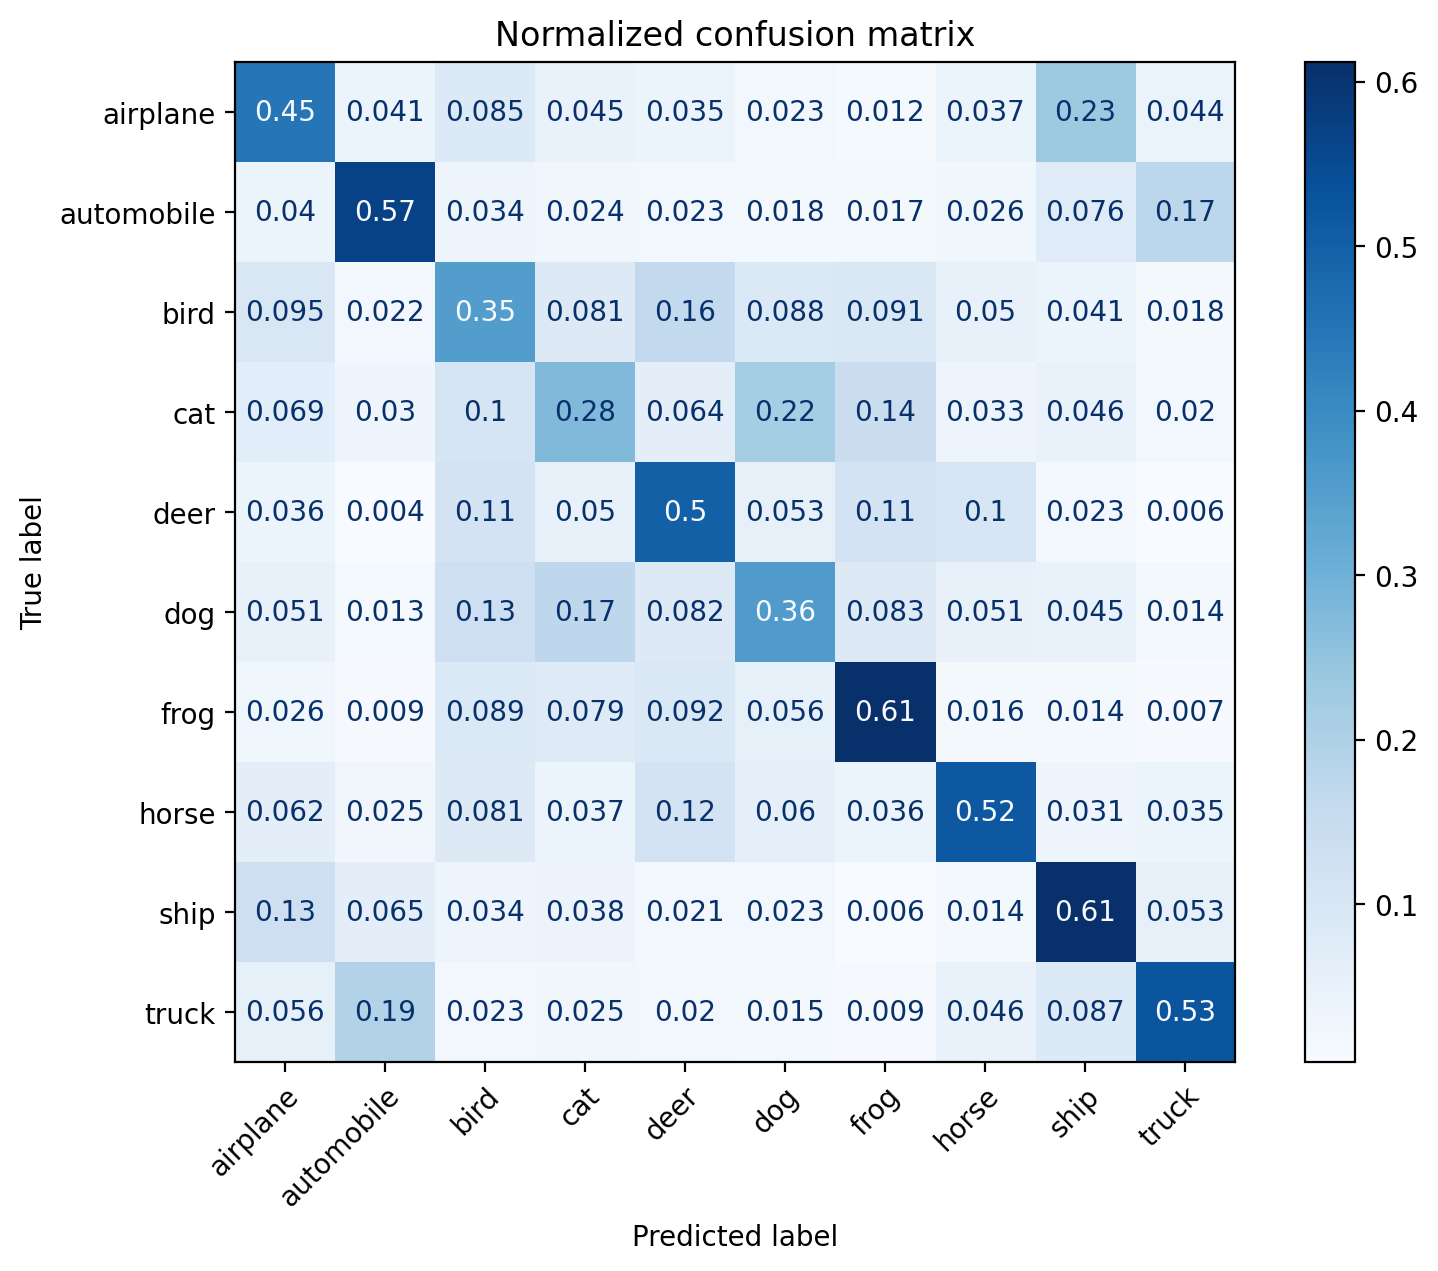

In [22]:
normed_c = confusion_matrix.numpy() / np.sum(confusion_matrix.numpy(), axis=1, keepdims=True)

fig_1 = plt.figure(figsize=(7, 5), dpi=200)
ax = fig_1.add_axes([0, 0, 1, 1])
ax.set_title("Normalized confusion matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=normed_c,
                              display_labels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
plt.show()